In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Download data

In [ ]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

f = open(csv_path)
data = f.read()
f.close()

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


# Explore dataset

In [ ]:
# Parse data
import numpy as np
 
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420551, 14)


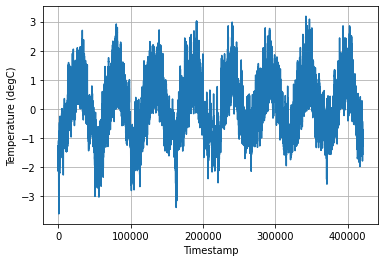

In [ ]:
temp = float_data[:, 1]
 
# Plot whole temperature series, notice yearly trends
plt.figure()
plt.plot(temp)
plt.grid()
plt.ylabel("Temperature (degC)")
plt.xlabel("Timestamp")
plt.show()

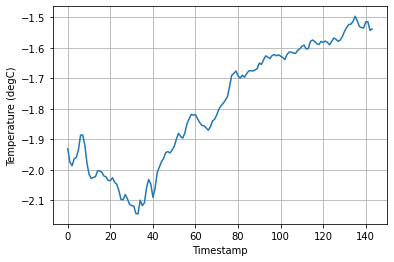

In [ ]:
# Plot the first few days
plt.figure()
plt.plot(temp[:144])
plt.grid()
plt.ylabel("Temperature (degC)")
plt.xlabel("Timestamp")
plt.show()

In [ ]:
# Normalize the data
train_set = float_data[:200000]

mean = train_set.mean(axis=0)
float_data -= mean

std = train_set.std(axis=0)
float_data /= std

# Set up data generators

In [ ]:
# generator function used to feed the training, validation and test data

def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
 
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
# Define lookback, step, delay and batch size variable
lookback = 720  # timestamp co 10 min
step = 6
delay = 144
batch_size = 128
 
train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
 
# Set a validation generator similar to train generator. 
# Use next 100000 samples (max index from 200,000 to 300,000). 
# Do not shuftle the data:
val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200001,
                        max_index=300000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)
 
# Set a test generator similar to a train generator. 
# Use further next 100000 samples (max index from 300,000 onwards). 
# Do not shuffle the data:
test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300001,
                        max_index=None,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

# Network training

In [ ]:
# Basic approach
from keras import Sequential, layers
from keras.optimizers import RMSprop

model_basic = Sequential()
model_basic.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model_basic.add(layers.Dense(32, activation='relu'))
model_basic.add(layers.Dense(1))

model_basic.summary()
 
model_basic.compile(optimizer=RMSprop(), loss='mae')
 
# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size 
 
# Train the network for about 20 epochs
history_basic = model_basic.fit_generator(train_gen,
                                          steps_per_epoch=500,
                                          epochs=20,
                                          validation_data=val_gen,
                                          validation_steps=val_steps)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1680)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                53792     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 53,825
Trainable params: 53,825
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 9s 15ms/step - loss: 1.1116 - val_loss: 0.5847
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3624 - val_loss: 0.3161
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2868 - val_loss: 0.3002
Epoch 4/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2715 - val_loss: 0.2833
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2591 - val_loss: 0.3010
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2526 - val_loss: 0.2921
Epoch 7/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2468 - val_loss: 0.2963
Epoch 8/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2464 - val_loss: 0.2863
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2398 - val_loss: 0.2824
Epoch 10/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2388 - val_lo

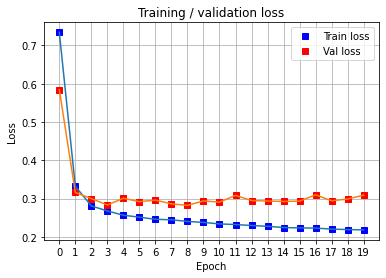

In [ ]:
# Plot the results

def plot_results(net_history_dict, num_epochs):
  epochs = np.arange(0, num_epochs)

  # Plot loss
  plt.plot(epochs, net_history_dict['loss'], 'bs', net_history_dict['val_loss'], 'rs')
  plt.plot(epochs, net_history_dict['loss'], net_history_dict['val_loss'])
  plt.xlabel('Epoch'), plt.ylabel('Loss')
  plt.title('Training / validation loss')
  plt.legend(('Train loss', 'Val loss'))
  plt.xticks(epochs)
  plt.grid(True)

  plt.show()

plot_results(history_basic.history, 20)

In [ ]:
# GRU layer
from keras.optimizers import Adam

model_gru = Sequential()
model_gru.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]), 
              return_sequences=False))
# model_gru.add(layers.GRU(32))
model_gru.add(layers.Dense(1))

model_gru.summary()

model_gru.compile(optimizer=Adam(), loss='mae')
 
# Train the network for about 20 epochs
history_gru = model_gru.fit_generator(train_gen,
                                      steps_per_epoch=500,
                                      epochs=20,
                                      validation_data=val_gen,
                                      validation_steps=val_steps)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 11s 20ms/step - loss: 0.3374 - val_loss: 0.2708
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2867 - val_loss: 0.2697
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2791 - val_loss: 0.2657
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2695 - val_loss: 0.2720
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2676 - val_loss: 0.2665
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2618 - val_loss: 0.2690
Epoch 7/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2548 - val_loss: 0.2752
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2538 - val_loss: 0.2735
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2472 - val_loss: 0.2838
Epoch 10/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2433 - val_loss: 0.2

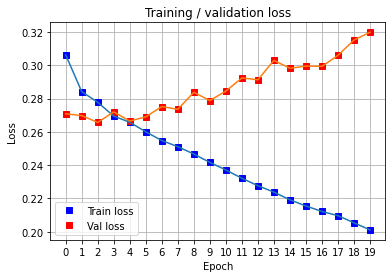

In [ ]:
plot_results(history_gru.history, 20)

In [ ]:
# Bidirectional GRU layer

model_bidir = Sequential()
model_bidir.add(layers.Bidirectional(layers.GRU(32), 
                                     input_shape= (None, float_data.shape[-1])))
model_bidir.add(layers.Dense(1))

model_bidir.summary()
 
model_bidir.compile(optimizer=Adam(), loss='mae')
 
# Train the network for about 40 epochs
history_bidir = model_bidir.fit_generator(train_gen,
                                          steps_per_epoch=500,
                                          epochs=40,
                                          validation_data=val_gen,
                                          validation_steps=val_steps)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                9216      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 15s 26ms/step - loss: 0.3663 - val_loss: 0.2696
Epoch 2/40
500/500 [==============================] - 13s 25ms/step - loss: 0.2744 - val_loss: 0.2661
Epoch 3/40
500/500 [==============================] - 13s 25ms/step - loss: 0.2666 - val_loss: 0.2673
Epoch 4/40
500/500 [==============================] - 13s 25ms/step - loss: 0.2631 - val_loss: 0.2679
Epoch 5/40
500/500 [==============================] - 13s 25ms/step - loss: 0.2535 - val_loss: 0.2709
Epoch 6/40
500/500 [==============================] - 13s 25ms/step - loss: 0.2510 - val_loss: 0.2741
Epoch 7/40
500/500 [==============================] - 13s 26ms/step - loss: 0.2410 - val_loss: 0.2764
Epoch 8/40
500/500 [==============================] - 13s 25ms/step - loss: 0.2340 - val_loss: 0.2834
Epoch 9/40
500/500 [==============================] - 13s 25ms/step - loss: 0.2261 - val_loss: 0.2836
Epoch 10/40
500/500 [==============================] - 13s 25ms/step - loss: 0.2202 - val_los

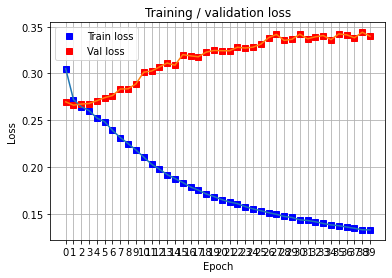

In [ ]:
plot_results(history_bidir.history, 40)

In [ ]:
# Conv1D layers

model_conv = Sequential()
model_conv.add(layers.Conv1D(32, 5, activation='relu',
               input_shape=(None, float_data.shape[-1])))
model_conv.add(layers.MaxPooling1D(3))
model_conv.add(layers.Conv1D(32, 5, activation='relu'))
# model_conv.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model_conv.add(layers.GRU(32))
model_conv.add(layers.Dense(1))

model_conv.summary()

model_conv.compile(optimizer=RMSprop(), loss='mae')
 
# Train the network for about 20 epochs
history_conv = model_conv.fit_generator(train_gen,
                                        steps_per_epoch=500,
                                        epochs=20,
                                        validation_data=val_gen,
                                        validation_steps=val_steps)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_10 (GRU)                 (None, 32)                6336      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 10s 17ms/step - loss: 0.3618 - val_loss: 0.2958
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2973 - val_loss: 0.3213
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2779 - val_loss: 0.2995
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2646 - val_loss: 0.3166
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2514 - val_loss: 0.3082
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2392 - val_loss: 0.3047
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2267 - val_loss: 0.3220
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2136 - val_loss: 0.3209
Epoch 9/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2016 - val_loss: 0.3313
Epoch 10/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1906 - val_loss: 0.3403

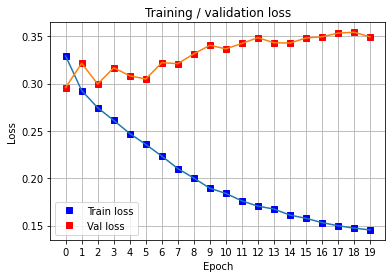

In [ ]:
plot_results(history_conv.history, 20)

In [ ]:
# LSTM

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1]),
                      return_sequences=False))
# model.add(layers.LSTM(32))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
 
# Train the network for about 20 epochs
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 11s 20ms/step - loss: 0.3288 - val_loss: 0.2721
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2799 - val_loss: 0.2750
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2680 - val_loss: 0.2763
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2579 - val_loss: 0.2769
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2515 - val_loss: 0.2774
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2441 - val_loss: 0.2837
Epoch 7/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2392 - val_loss: 0.2845
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2300 - val_loss: 0.2867
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2221 - val_loss: 0.2916
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2219 - val_loss: 0.29

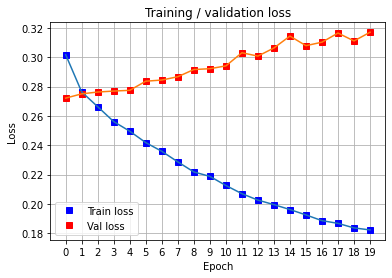

In [ ]:
plot_results(history.history, 20)

# Models comparison

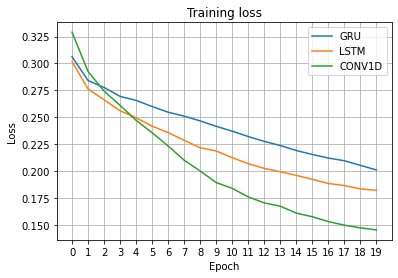

In [ ]:
  epochs = np.arange(0, 20)

  # Plot training loss
  plt.plot(epochs, history_gru.history['loss'], label='GRU')
  plt.plot(epochs, history.history['loss'], label='LSTM')
  plt.plot(epochs, history_conv.history['loss'], label='CONV1D')

  plt.xlabel('Epoch'), plt.ylabel('Loss')
  plt.title('Training loss')
  plt.legend(('GRU', 'LSTM', 'CONV1D'))
  plt.xticks(epochs)
  plt.grid(True)

  plt.show()

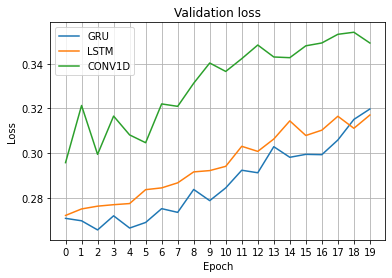

In [ ]:
  # Plot validation loss
  plt.plot(epochs, history_gru.history['val_loss'], label='GRU')
  plt.plot(epochs, history.history['val_loss'], label='LSTM')
  plt.plot(epochs, history_conv.history['val_loss'], label='CONV1D')

  plt.xlabel('Epoch'), plt.ylabel('Loss')
  plt.title('Validation loss')
  plt.legend(('GRU', 'LSTM', 'CONV1D'))
  plt.xticks(epochs)
  plt.grid(True)

  plt.show()

Podsumowanie: 
  Porównano trzy modele: GRU, LSTM oraz CONV1D. Najlepsze rezultaty dla zbioru treningowego daje model z konwolucją 1D. Ma on jednak zdecydowanie największy błąd na zbiorze walidacyjnym, gdzie pozostałe dwa modele radzą sobie lepiej. Widać, że błąd na zbiorze walidacyjnym rośnie w przypadku wszystkich modeli, co wskazuje na overfitting. 
  Dodanie do warstw GRU parametrów 'dropout' i 'recurrent_dropout' powoduje, że trening jest bardzo długi. Pojawia się warning, że nie wykorzystywany jest kernel cuDNN. W przypadku warstwy GRU bez dropoutu nie ma takiego problemu. Bidirectional GRU nie poprawia rezultatów, gdyż dane pogodowe w odwrotnej kolejności nie wnoszą wiele nowych istotnych informacji.